In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os
from Bio.Seq import Seq

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

# Reading in Error corrected umi results

In [3]:
ADBC_reads_per_umi_ec = pd.read_csv("../../output/TL4_umi_results_whitelist_concat/ADBC_reads_per_umi.csv")
ADBC_reads_per_umi_ec

,Unnamed: 0,ADBC2,HawkBCs,UMI,reads,name
0,0,AAAAAT,CATCTTAGG,TTGATTAGGCCT,5,a2_RNA_ADBC_S18
1,1,AAAAAT,CATCTTAGG,TGCTAACGAGAA,4,a2_RNA_ADBC_S18
2,2,AAAAAT,CATCTTAGG,ACTTGTGCGTAG,4,a2_RNA_ADBC_S18
3,3,AAAAAT,CATCTTAGG,CCAACCAAACAA,4,a2_RNA_ADBC_S18
4,4,AAAAAT,CATCTTAGG,GTAAACCCCCAC,4,a2_RNA_ADBC_S18
...,...,...,...,...,...,...
2406263,93753,TTAGGC,CAACAGTGC,TTACGCGCGCAT,1,a5_RNA_ADBC_S21
2406264,93754,TTAGGC,CAACAGTGC,AGCGTGGCCGTC,1,a5_RNA_ADBC_S21
2406265,93755,TTAGGC,CAACAGTGC,TTTCTGGACCTG,1,a5_RNA_ADBC_S21
2406266,93756,TTAGGC,CAACAGTGC,ACATGGAAAGCA,1,a5_RNA_ADBC_S21


In [4]:
RTBC_reads_per_umi_ec = pd.read_csv("../../output/TL4_umi_results_whitelist_concat/RTBC_reads_per_umi.csv")
RTBC_reads_per_umi_ec

,Unnamed: 0,RTBC,UMI,reads,name
0,0,AAAAAACCCTTAAGTA,CCCGATTACCTT,4,r2_RNA_RTBC_S26
1,1,AAAAAACCCTTAAGTA,CCGCTGTCGCGC,4,r2_RNA_RTBC_S26
2,2,AAAAAACCCTTAAGTA,AACTCCCGGACT,4,r2_RNA_RTBC_S26
3,3,AAAAAACCCTTAAGTA,CTAACTGCGACT,4,r2_RNA_RTBC_S26
4,4,AAAAAACCCTTAAGTA,TCCCCTACTATA,4,r2_RNA_RTBC_S26
...,...,...,...,...,...
3121019,437771,TTTCTAATTCAACATC,TAATCGCAAGAC,1,r4_RNA_RTBC_S28
3121020,437772,TTTCTAATTCAACATC,GCCCACCAGTAT,1,r4_RNA_RTBC_S28
3121021,437773,TTTCTAATTCAACATC,CAACGCCACTCA,1,r4_RNA_RTBC_S28
3121022,437774,TTTCTAATTCAACATC,AAAACCAAGAGT,1,r4_RNA_RTBC_S28


# Reading in pre error correction umi results

In [8]:
ADBC_reads_per_umi = pd.read_csv("../../output/TL4_umi_results/ADBC_reads_per_umi.csv")
ADBC_reads_per_umi

,Unnamed: 0,ADBC2,HawkBCs,UMI,reads,name
0,0,AAAAAA,AACTCCGTA,CGATGAAATCAC,1,a2_RNA_ADBC_S18
1,1,AAAAAA,ACTCCTGCA,GGTTAACGTAGA,1,a2_RNA_ADBC_S18
2,2,AAAAAA,ACTCGTGCA,TGAGAAATCAGT,1,a2_RNA_ADBC_S18
3,3,AAAAAA,ACTCTTGCA,AAAAACTAACTT,4,a2_RNA_ADBC_S18
4,4,AAAAAA,ACTCTTGCA,ACTCGAAACTTC,3,a2_RNA_ADBC_S18
...,...,...,...,...,...,...
4044714,516321,TTTTTT,AGAGGAGTT,TGCGAAATGGCA,1,a5_RNA_ADBC_S21
4044715,516322,TTTTTT,AGAGGAGTT,ACACTTTTTACT,1,a5_RNA_ADBC_S21
4044716,516323,TTTTTT,AGAGGAGTT,TATGAATCGGGA,1,a5_RNA_ADBC_S21
4044717,516324,TTTTTT,AGAGGCGTT,ACTCATGAAAAT,1,a5_RNA_ADBC_S21


In [9]:
RTBC_reads_per_umi = pd.read_csv("../../output/TL4_umi_results/RTBC_reads_per_umi.csv")
RTBC_reads_per_umi

,Unnamed: 0,RTBC,UMI,reads,name
0,0,AAAAAAAAAAAACGAT,CGAAATCAACTT,2,r2_RNA_RTBC_S26
1,1,AAAAAAAAAAAACGAT,CTCCCCATCACC,1,r2_RNA_RTBC_S26
2,2,AAAAAAAAAAAACGAT,CTATATACGTGA,1,r2_RNA_RTBC_S26
3,3,AAAAAAAAAAAACGAT,GCGTACGACTCA,1,r2_RNA_RTBC_S26
4,4,AAAAAAAAAAAACGAT,GACACAATTGCA,1,r2_RNA_RTBC_S26
...,...,...,...,...,...
4701808,1027833,TTTTTAGCCGTCATCT,CATCTCTAGGCT,1,r4_RNA_RTBC_S28
4701809,1027834,TTTTTGTACGAGTAGA,GCCGATTTTTGT,1,r4_RNA_RTBC_S28
4701810,1027835,TTTTTGTACGAGTAGA,AGATGTCCATAT,1,r4_RNA_RTBC_S28
4701811,1027836,TTTTTTGAATTTTTAT,TGGAAAAGTAAC,1,r4_RNA_RTBC_S28


# Comparing reads per UMI

1.2652100474948158
1.2620374434626616

1.2497886611510691
1.2462414534341655

1.3199388716071028
1.3154450084471392

1.3623293680636266
1.3578517526379406

1.3694511401693723
1.3619108857582225

1.3061162446030126
1.3016008846143068

1.2827807265458055
1.278947723942914

1.31748499324838
1.3139480727792754



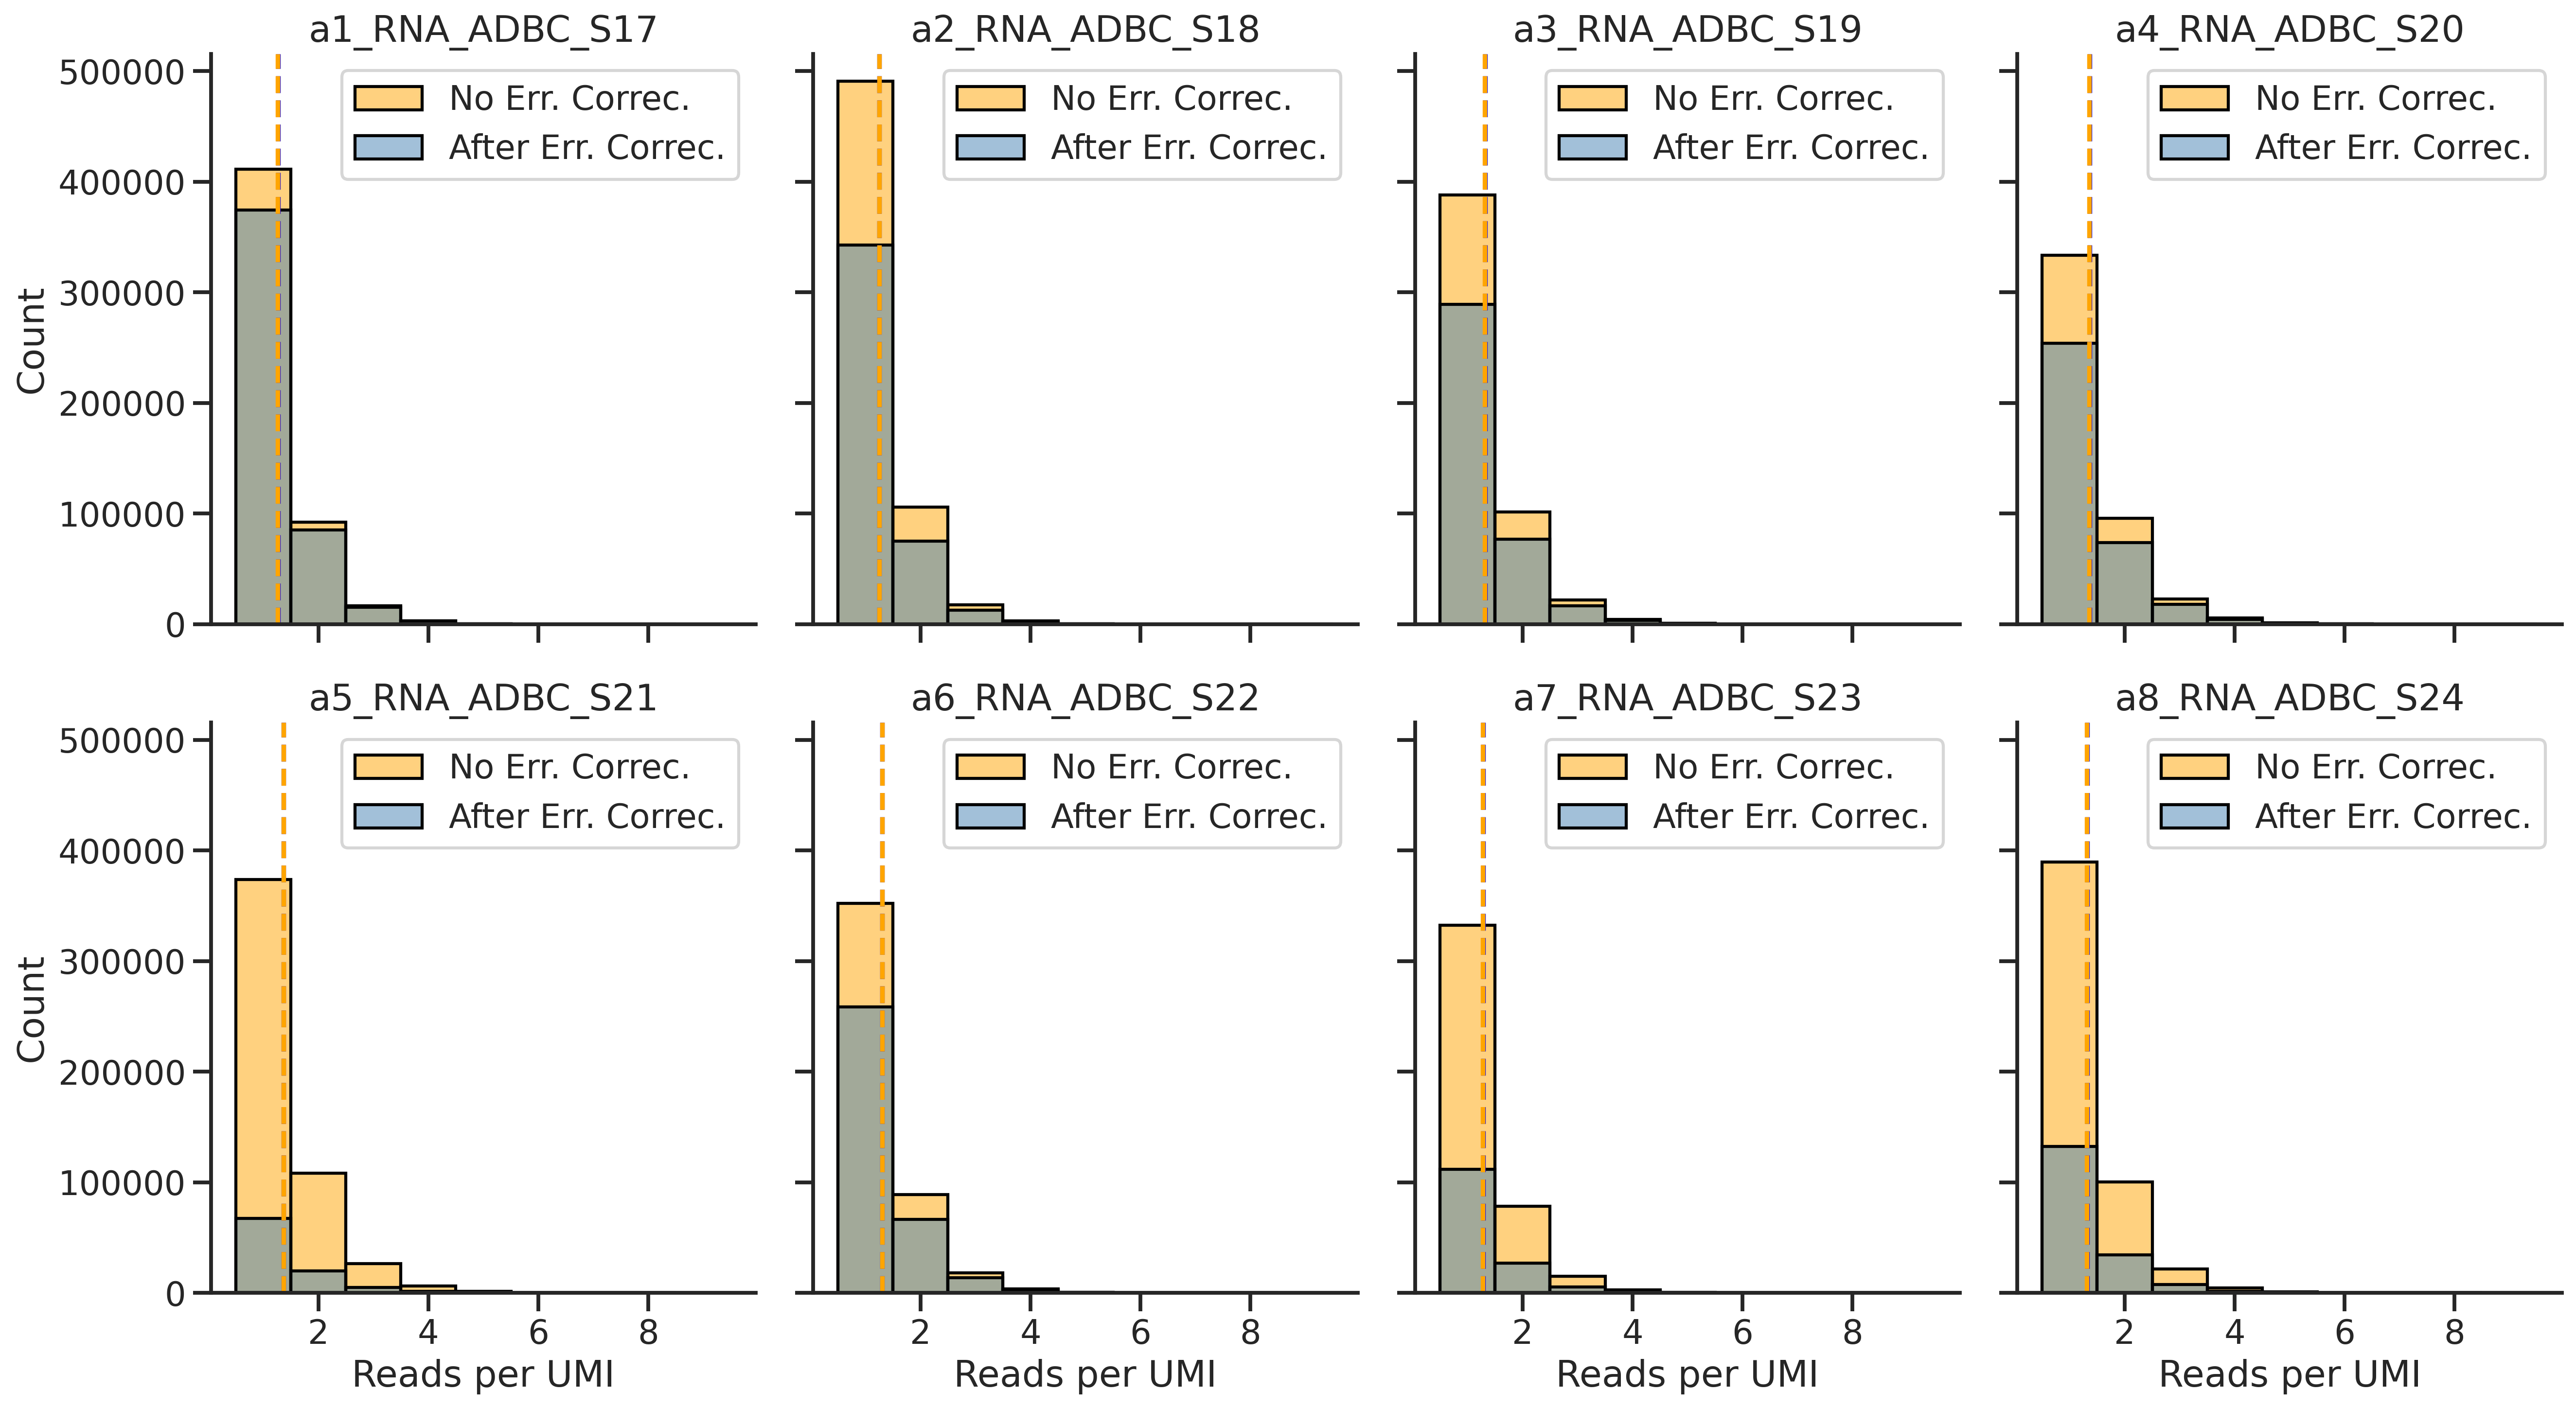

In [17]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# group both dataframes by "name"
groups_EC = dict(tuple(ADBC_reads_per_umi_ec.groupby("name")))
groups = dict(tuple(ADBC_reads_per_umi.groupby("name")))

# sorted sample names that exist in both
names = sorted(set(groups_EC.keys()) & set(groups.keys()))
n = len(names)

rows = math.ceil(n / 4)
cols = 4

sns.set_context('talk')
sns.set_style('ticks')

fig, axes = plt.subplots(
    rows, cols,
    figsize=(18, 5 * rows),
    sharey=True, sharex=True,
    dpi=300
)

axes = axes.flatten()

for ax, name in zip(axes, names):

    df_EC = groups_EC[name]
    df = groups[name]
    
    # plot dataframe 2
    sns.histplot(
        df["reads"], bins=50, discrete=True,
        color="orange", edgecolor="black",
        alpha=0.5, ax=ax, label="No Err. Correc."
    )
    
    # plot dataframe 1
    sns.histplot(
        df_EC["reads"], bins=50, discrete=True,
        color="steelblue", edgecolor="black",
        alpha=0.5, ax=ax, label="After Err. Correc."
    )



    # add mean lines
    ax.axvline(df_EC["reads"].mean(), color="blue", ls="--")
    ax.axvline(df["reads"].mean(), color="orange", ls="--")

    print(df_EC["reads"].mean())
    print(df["reads"].mean())
    print()

    ax.set_title(name)
    ax.set_xlabel("Reads per UMI")
    ax.set_ylabel("Count")

    ax.legend()
    sns.despine(ax=ax)

# hide unused axes
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


1.540204337025346
1.530620700088362

1.2950550987590121
1.2894528422271205

1.6631841420415392
1.651253355373624

1.5160196082014545
1.5079866671596107

1.7962779902866721
1.7752750646512228

1.5533851379647294
1.5403752358690754

1.694827114002054
1.6824113411239703

1.4217979335417847
1.4144652437602052



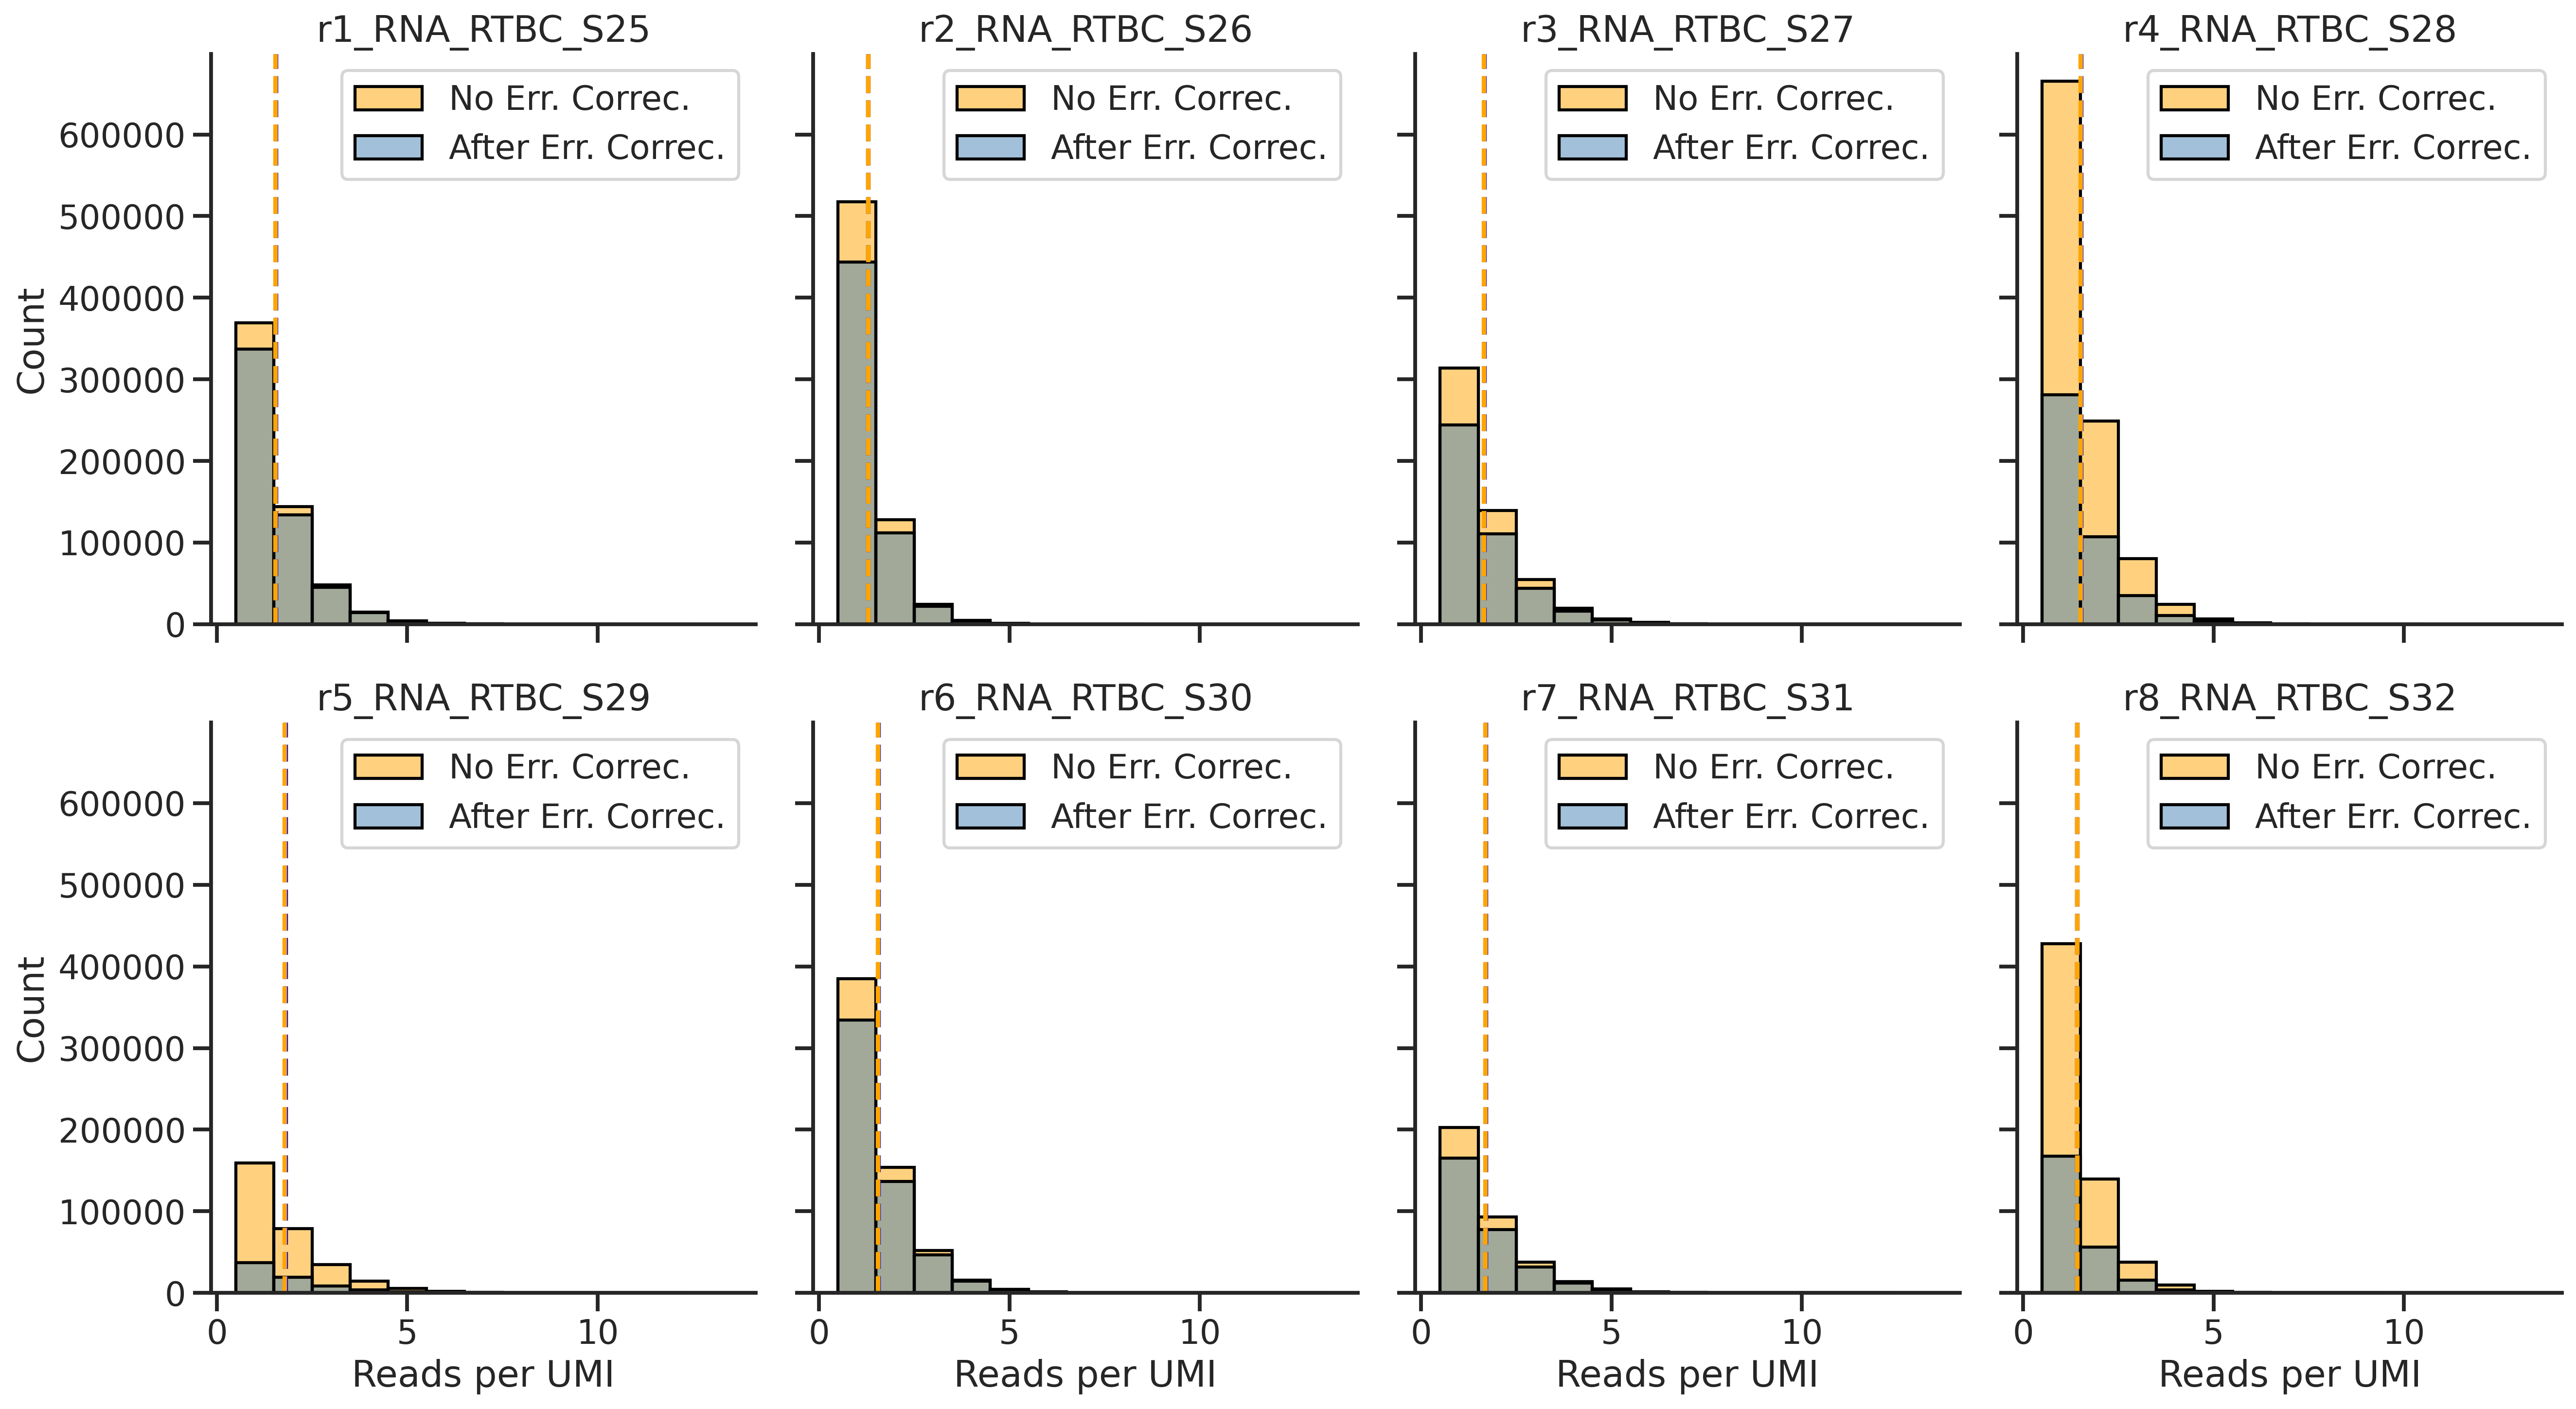

In [18]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# group both dataframes by "name"
groups_EC = dict(tuple(RTBC_reads_per_umi_ec.groupby("name")))
groups = dict(tuple(RTBC_reads_per_umi.groupby("name")))

# sorted sample names that exist in both
names = sorted(set(groups_EC.keys()) & set(groups.keys()))
n = len(names)

rows = math.ceil(n / 4)
cols = 4

sns.set_context('talk')
sns.set_style('ticks')

fig, axes = plt.subplots(
    rows, cols,
    figsize=(18, 5 * rows),
    sharey=True, sharex=True,
    dpi=300
)

axes = axes.flatten()

for ax, name in zip(axes, names):

    df_EC = groups_EC[name]
    df = groups[name]
    
    # plot dataframe 2
    sns.histplot(
        df["reads"], bins=50, discrete=True,
        color="orange", edgecolor="black",
        alpha=0.5, ax=ax, label="No Err. Correc."
    )
    
    # plot dataframe 1
    sns.histplot(
        df_EC["reads"], bins=50, discrete=True,
        color="steelblue", edgecolor="black",
        alpha=0.5, ax=ax, label="After Err. Correc."
    )



    # add mean lines
    ax.axvline(df_EC["reads"].mean(), color="blue", ls="--")
    ax.axvline(df["reads"].mean(), color="orange", ls="--")

    print(df_EC["reads"].mean())
    print(df["reads"].mean())
    print()

    ax.set_title(name)
    ax.set_xlabel("Reads per UMI")
    ax.set_ylabel("Count")

    ax.legend()
    sns.despine(ax=ax)

# hide unused axes
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Comparing reads per BC

In [26]:
ADBC_reads_per_BC = ADBC_reads_per_umi[["ADBC2", "HawkBCs", "reads", "name"]].groupby(["ADBC2", "HawkBCs", "name"]).sum().reset_index()
ADBC_reads_per_BC

,ADBC2,HawkBCs,name,reads
0,AAAAAA,AAATTCGTT,a1_RNA_ADBC_S17,1
1,AAAAAA,AACTCCGTA,a2_RNA_ADBC_S18,1
2,AAAAAA,AATATAGTA,a5_RNA_ADBC_S21,1
3,AAAAAA,ACAATAATC,a3_RNA_ADBC_S19,1
4,AAAAAA,ACATGGTCA,a4_RNA_ADBC_S20,1
...,...,...,...,...
37369,TTTTTT,AGGGGAGTT,a7_RNA_ADBC_S23,1
37370,TTTTTT,AGGGGAGTT,a8_RNA_ADBC_S24,1
37371,TTTTTT,ATATGCGGA,a8_RNA_ADBC_S24,1
37372,TTTTTT,GGAGGAGTT,a1_RNA_ADBC_S17,3


In [27]:
ADBC_reads_per_BC_ec = ADBC_reads_per_umi_ec[["ADBC2", "HawkBCs", "reads", "name"]].groupby(["ADBC2", "HawkBCs", "name"]).sum().reset_index()
ADBC_reads_per_BC_ec

,ADBC2,HawkBCs,name,reads
0,AAAAAA,ACTCTTGCA,a1_RNA_ADBC_S17,366
1,AAAAAA,ATTCTCGCC,a1_RNA_ADBC_S17,362
2,AAAAAT,ATACCGTCG,a1_RNA_ADBC_S17,327
3,AAAAAT,ATACCGTCG,a4_RNA_ADBC_S20,687
4,AAAAAT,CATCTTAGG,a1_RNA_ADBC_S17,2174
...,...,...,...,...
1901,TTTTTT,AGAGGAGTT,a1_RNA_ADBC_S17,877
1902,TTTTTT,AGAGGAGTT,a2_RNA_ADBC_S18,1049
1903,TTTTTT,AGAGGAGTT,a3_RNA_ADBC_S19,776
1904,TTTTTT,AGAGGAGTT,a4_RNA_ADBC_S20,748


1054.418118466899
140.97100831379237

2217.627049180328
149.3826154443151

1565.8159509202453
140.6179147703765

1406.5970588235293
134.4282018111255

7133.166666666667
149.5194556665958

1590.0640569395018
140.2678281068525

3050.7049180327867
129.74338374291116

3745.3548387096776
141.14780984014948



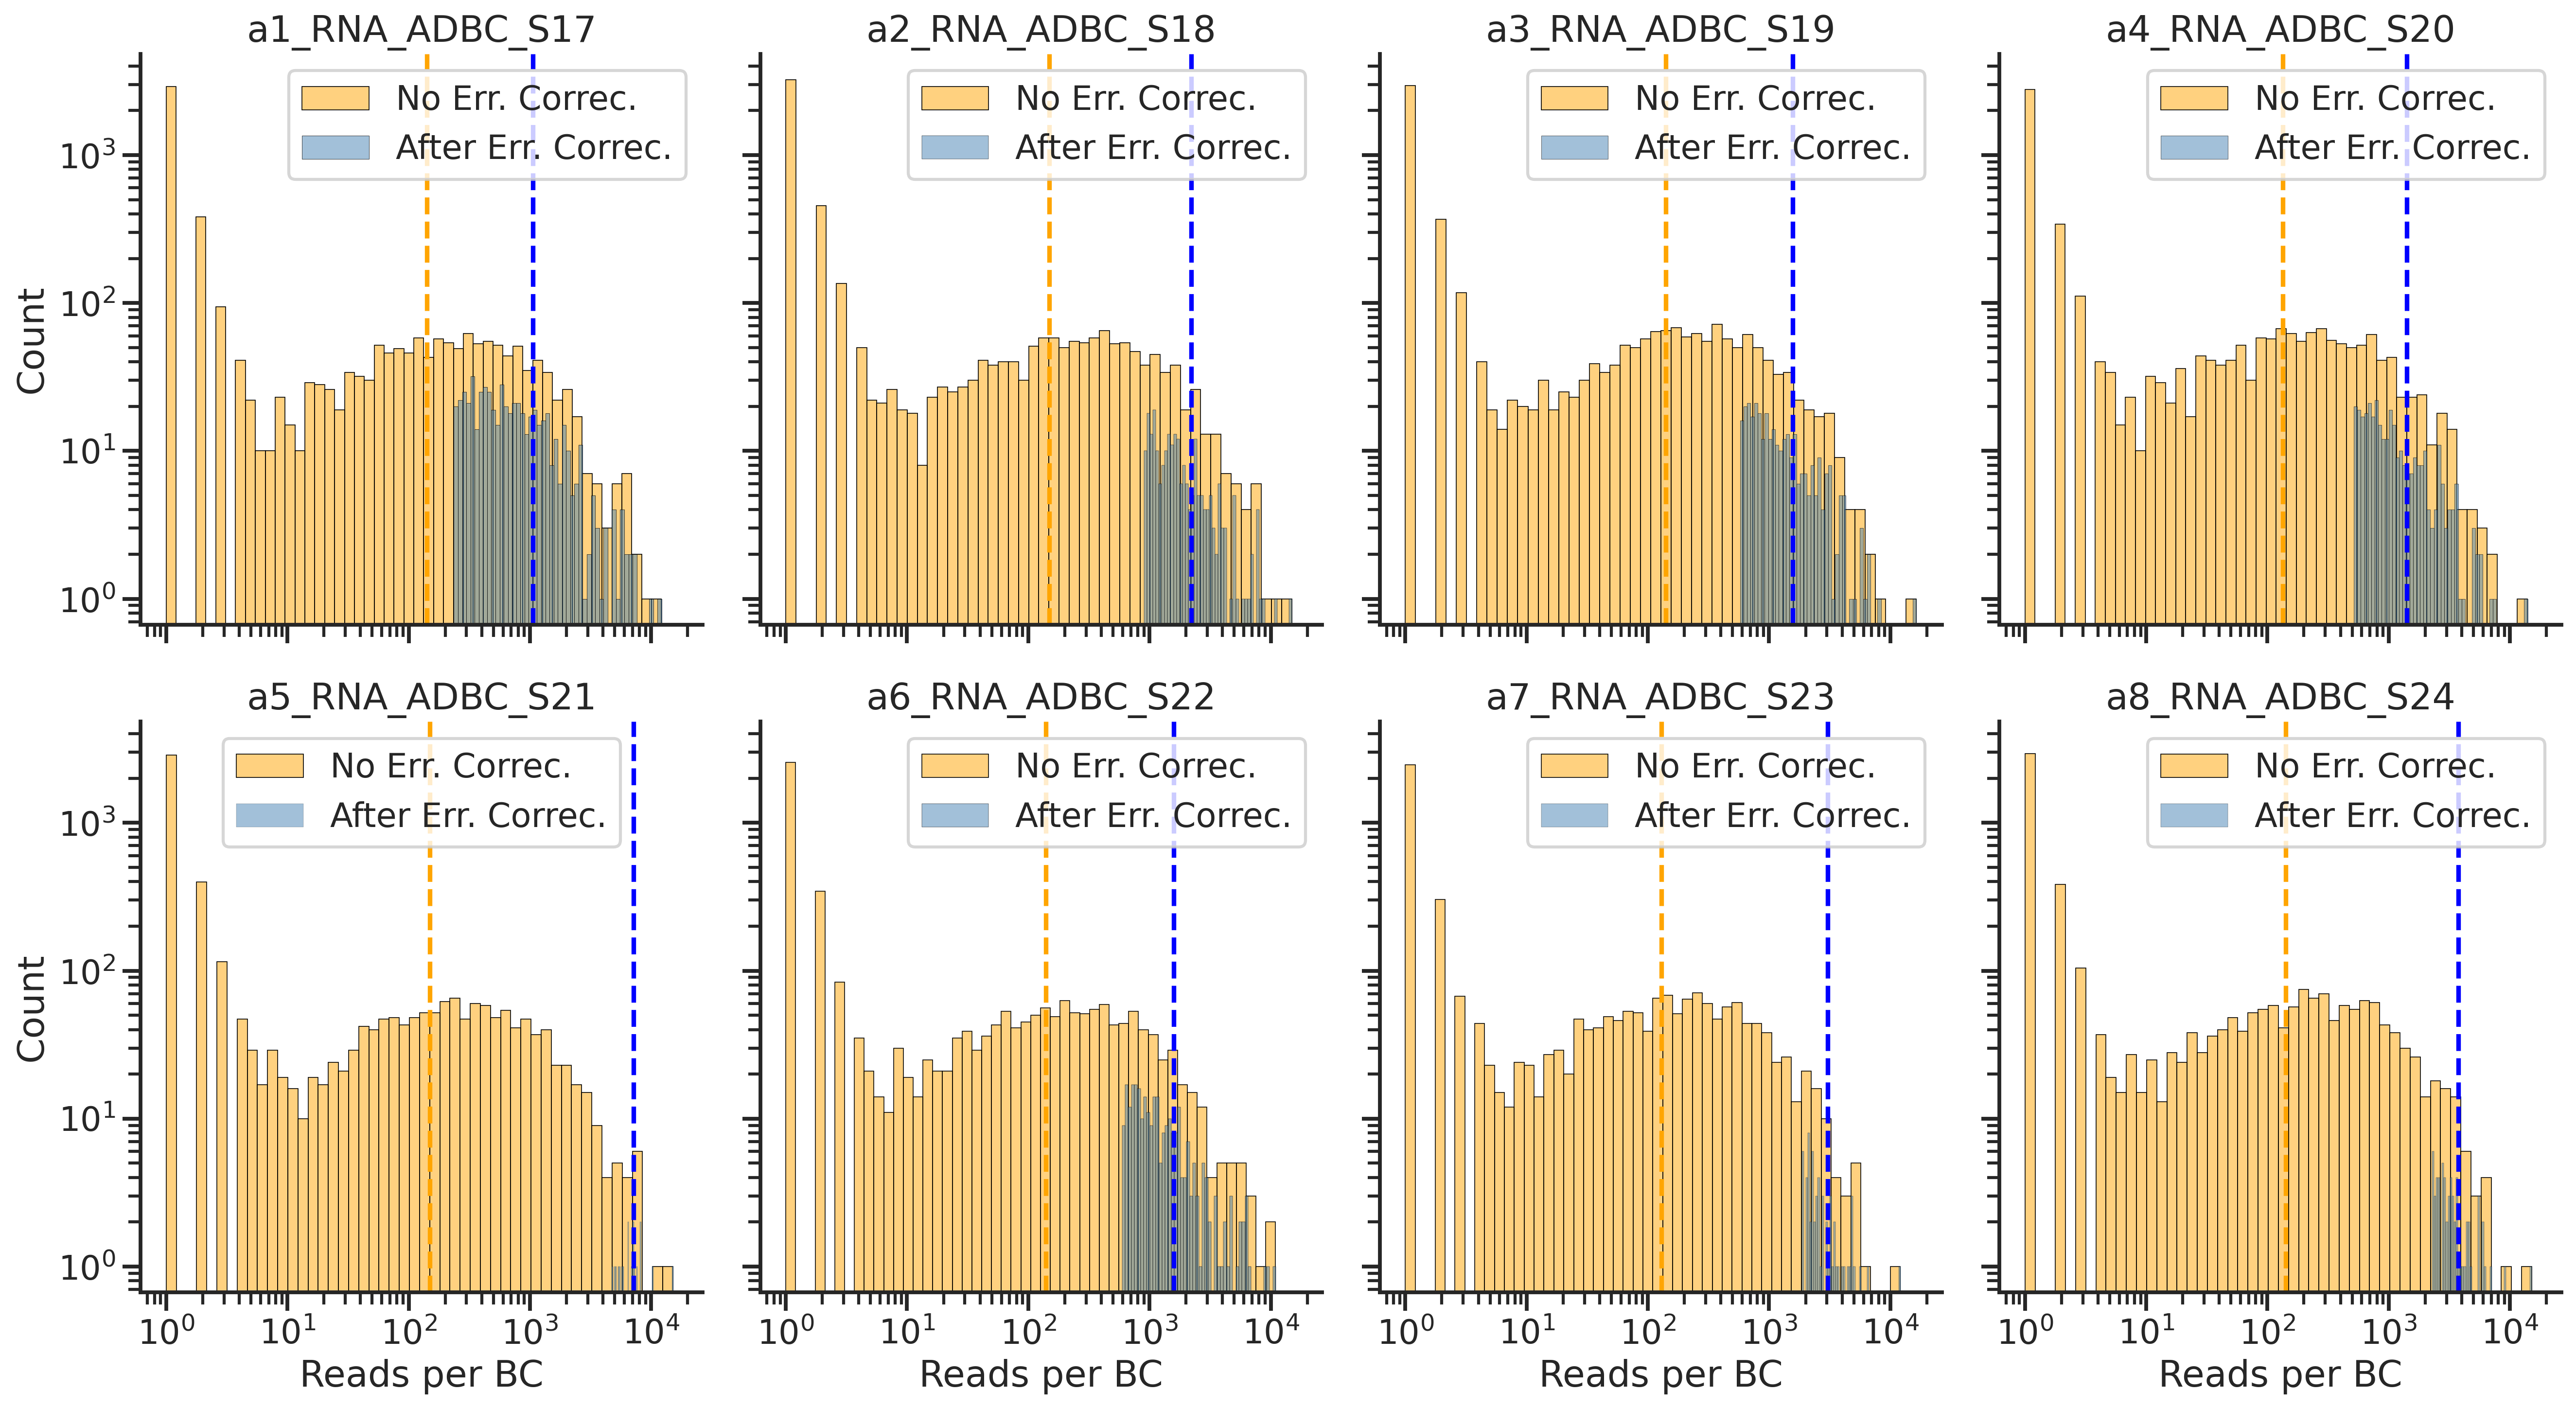

In [32]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# group both dataframes by "name"
groups_EC = dict(tuple(ADBC_reads_per_BC_ec.groupby("name")))
groups = dict(tuple(ADBC_reads_per_BC.groupby("name")))

# sorted sample names that exist in both
names = sorted(set(groups_EC.keys()) & set(groups.keys()))
n = len(names)

rows = math.ceil(n / 4)
cols = 4

sns.set_context('talk')
sns.set_style('ticks')

fig, axes = plt.subplots(
    rows, cols,
    figsize=(18, 5 * rows),
    sharey=True, sharex=True,
    dpi=300
)

axes = axes.flatten()

for ax, name in zip(axes, names):

    df_EC = groups_EC[name]
    df = groups[name]
    
    # plot dataframe 2
    sns.histplot(
        df["reads"], bins = 50,
        color="orange", edgecolor="black",
        alpha=0.5, ax=ax, label="No Err. Correc.", log_scale  = (True, True)
    )
    
    # plot dataframe 1
    sns.histplot(
        df_EC["reads"], bins = 50,
        color="steelblue", edgecolor="black",
        alpha=0.5, ax=ax, label="After Err. Correc.", log_scale  = (True, True)
    )



    # add mean lines
    ax.axvline(df_EC["reads"].mean(), color="blue", ls="--")
    ax.axvline(df["reads"].mean(), color="orange", ls="--")

    print(df_EC["reads"].mean())
    print(df["reads"].mean())
    print()

    ax.set_title(name)
    ax.set_xlabel("Reads per BC")
    ax.set_ylabel("Count")

    ax.legend()
    sns.despine(ax=ax)

# hide unused axes
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [34]:
RTBC_reads_per_BC = RTBC_reads_per_umi[["RTBC", "reads", "name"]].groupby(["RTBC", "name"]).sum().reset_index()
RTBC_reads_per_BC

,RTBC,name,reads
0,AAAAAAAAAAAAATTA,r5_RNA_RTBC_S29,1
1,AAAAAAAAAAAACGAT,r1_RNA_RTBC_S25,2
2,AAAAAAAAAAAACGAT,r2_RNA_RTBC_S26,10
3,AAAAAAAAAAAACGAT,r3_RNA_RTBC_S27,5
4,AAAAAAAAAAAACGAT,r4_RNA_RTBC_S28,9
...,...,...,...
48144,TTTTTTCGCCAAGACC,r6_RNA_RTBC_S30,5
48145,TTTTTTGAATAATTAT,r3_RNA_RTBC_S27,1
48146,TTTTTTGAATTTTTAT,r1_RNA_RTBC_S25,1
48147,TTTTTTGAATTTTTAT,r4_RNA_RTBC_S28,2


In [36]:
RTBC_reads_per_BC_ec = RTBC_reads_per_umi_ec[["RTBC", "reads", "name"]].groupby(["RTBC", "name"]).sum().reset_index()
RTBC_reads_per_BC_ec

,RTBC,name,reads
0,AAAAAACCCTTAAGTA,r1_RNA_RTBC_S25,1052
1,AAAAAACCCTTAAGTA,r2_RNA_RTBC_S26,1152
2,AAAAAACCCTTAAGTA,r6_RNA_RTBC_S30,737
3,AAAAAATATCATCGAC,r3_RNA_RTBC_S27,725
4,AAAAAATATCATCGAC,r7_RNA_RTBC_S31,549
...,...,...,...
2541,TTTTGCTATCAATATG,r6_RNA_RTBC_S30,3563
2542,TTTTGCTATCAATATG,r7_RNA_RTBC_S31,393
2543,TTTTTAAATCAAAGGT,r3_RNA_RTBC_S27,975
2544,TTTTTAAATCAAAGGT,r7_RNA_RTBC_S31,419


1385.8991596638655
150.7294735060098

1640.4434782608696
141.9320514909565

1858.0978835978835
149.2094196804037

6842.030927835051
171.45641592920353

5451.391304347826
128.14772170504654

1703.2551020408164
151.3515637530072

1175.9121140142518
130.9035510740903

4225.548780487805
139.9117128665278



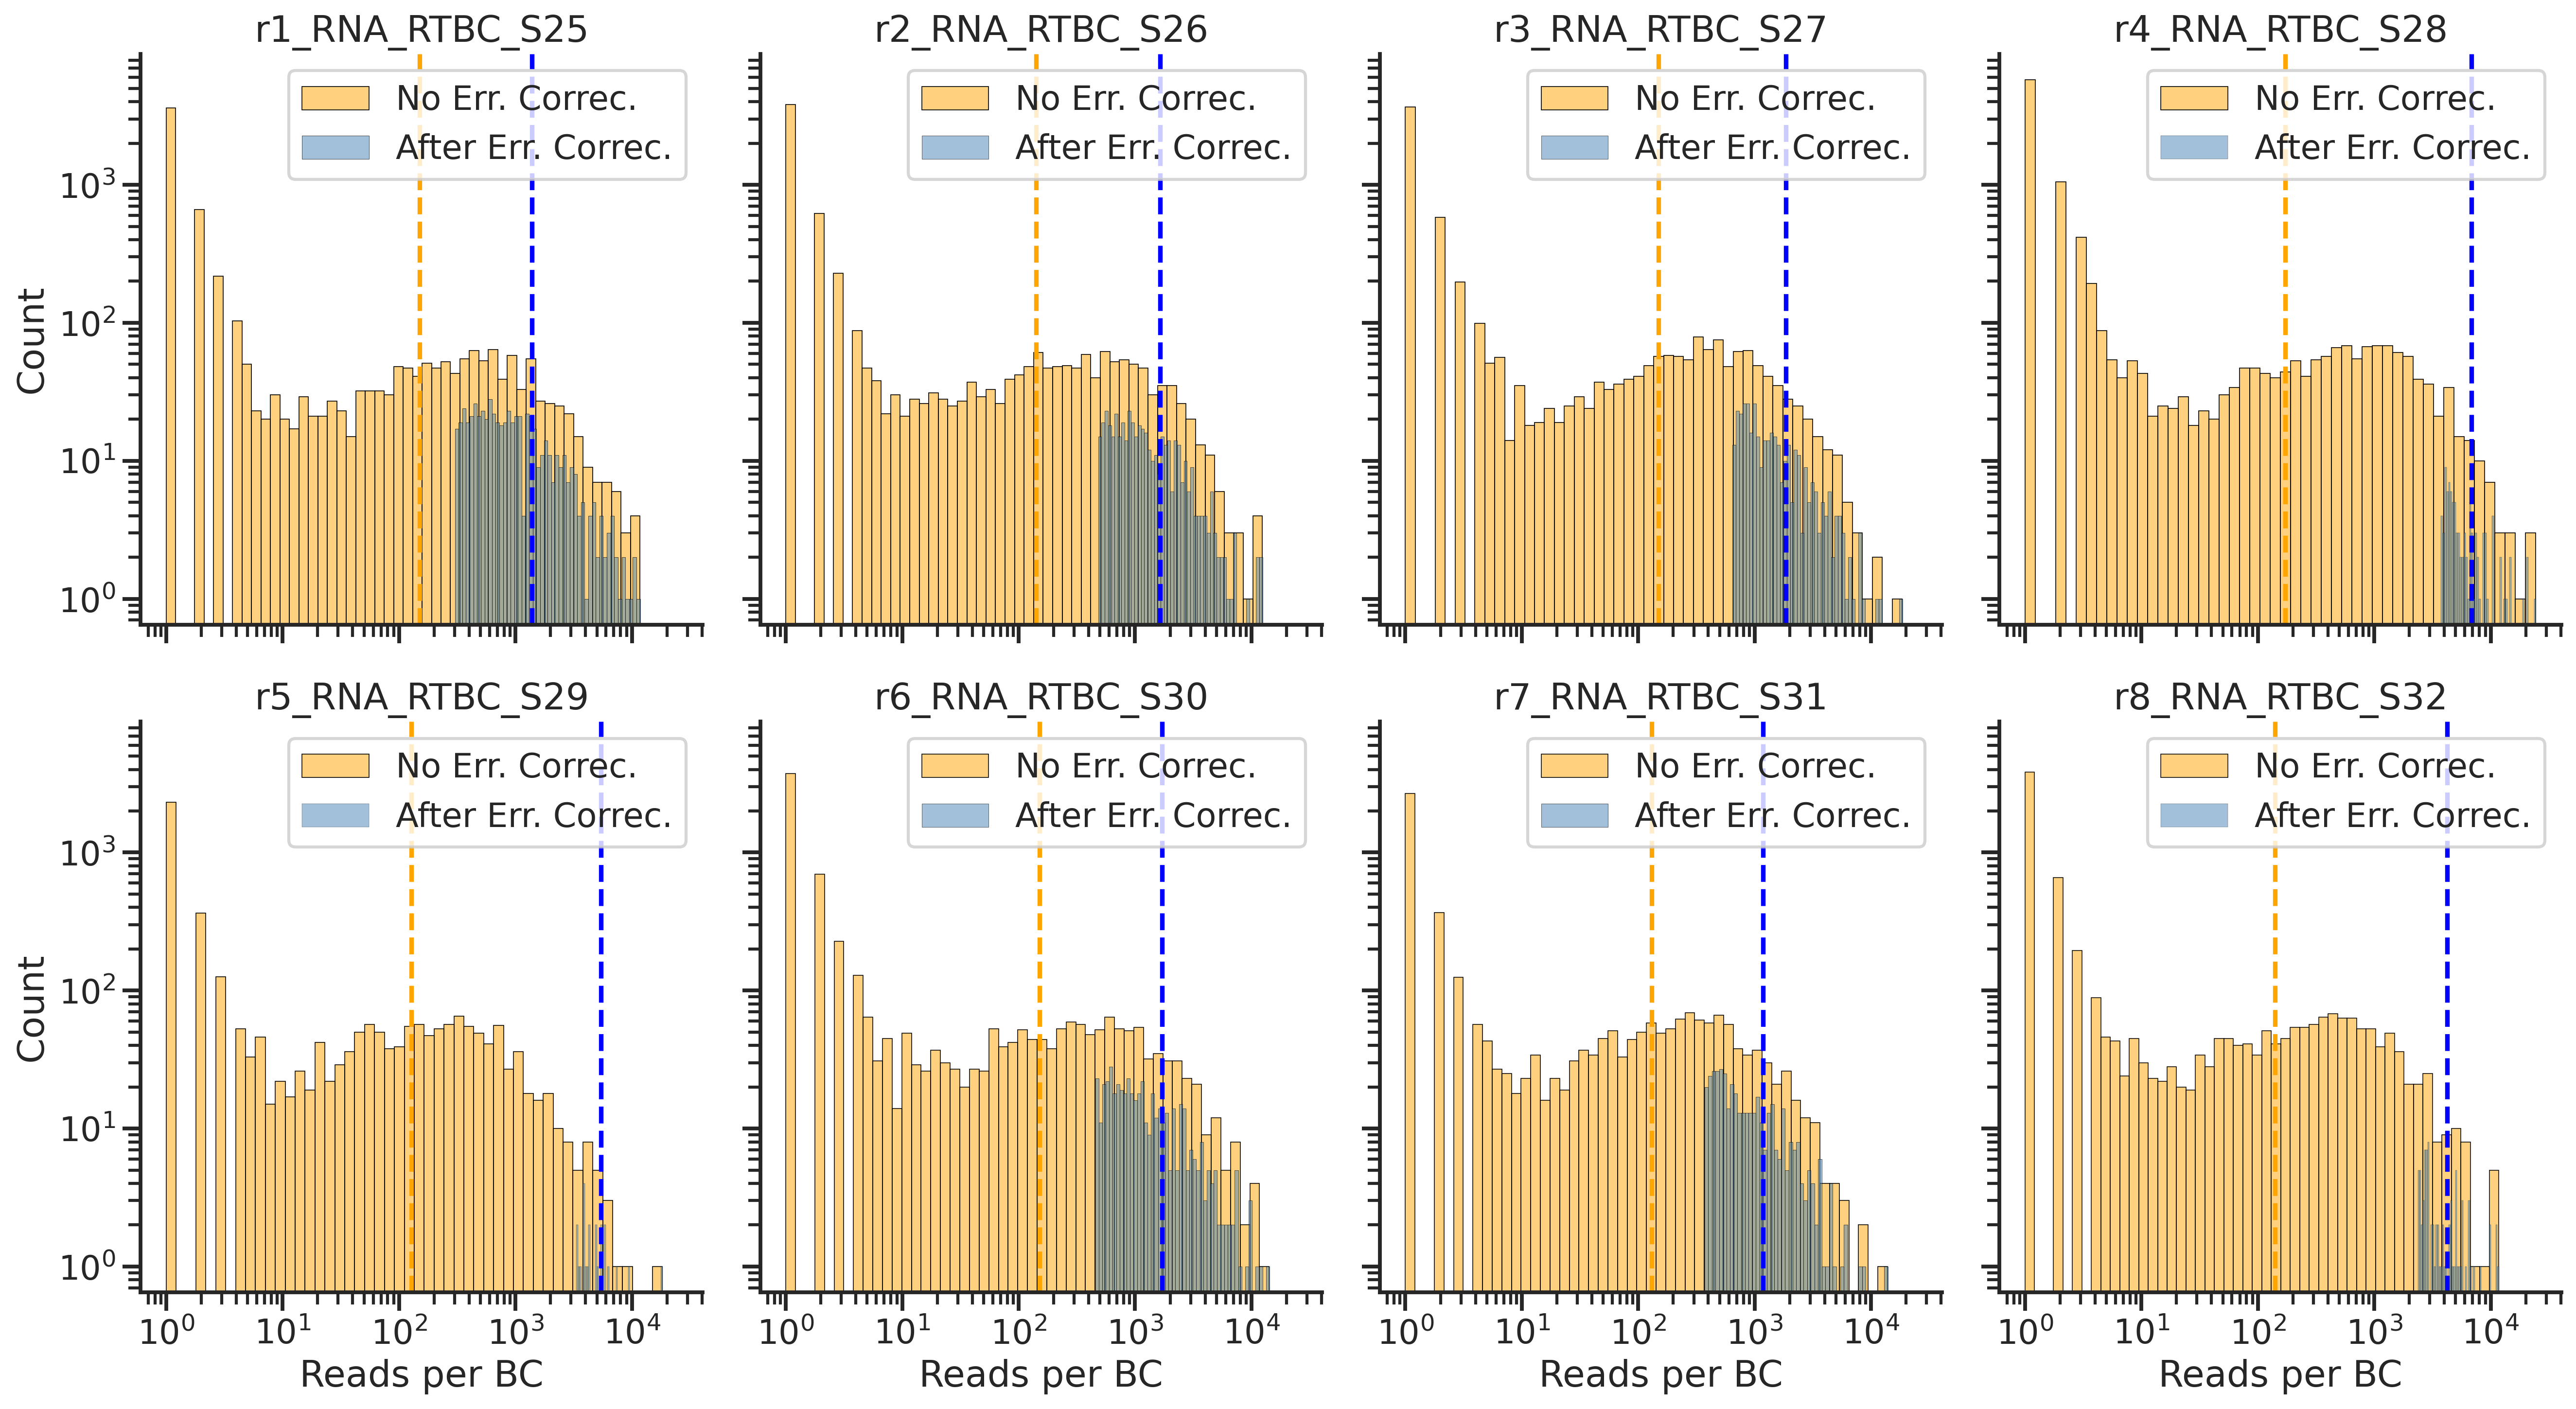

In [37]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# group both dataframes by "name"
groups_EC = dict(tuple(RTBC_reads_per_BC_ec.groupby("name")))
groups = dict(tuple(RTBC_reads_per_BC.groupby("name")))

# sorted sample names that exist in both
names = sorted(set(groups_EC.keys()) & set(groups.keys()))
n = len(names)

rows = math.ceil(n / 4)
cols = 4

sns.set_context('talk')
sns.set_style('ticks')

fig, axes = plt.subplots(
    rows, cols,
    figsize=(18, 5 * rows),
    sharey=True, sharex=True,
    dpi=300
)

axes = axes.flatten()

for ax, name in zip(axes, names):

    df_EC = groups_EC[name]
    df = groups[name]
    
    # plot dataframe 2
    sns.histplot(
        df["reads"], bins = 50,
        color="orange", edgecolor="black",
        alpha=0.5, ax=ax, label="No Err. Correc.", log_scale  = (True, True)
    )
    
    # plot dataframe 1
    sns.histplot(
        df_EC["reads"], bins = 50,
        color="steelblue", edgecolor="black",
        alpha=0.5, ax=ax, label="After Err. Correc.", log_scale  = (True, True)
    )



    # add mean lines
    ax.axvline(df_EC["reads"].mean(), color="blue", ls="--")
    ax.axvline(df["reads"].mean(), color="orange", ls="--")

    print(df_EC["reads"].mean())
    print(df["reads"].mean())
    print()

    ax.set_title(name)
    ax.set_xlabel("Reads per BC")
    ax.set_ylabel("Count")

    ax.legend()
    sns.despine(ax=ax)

# hide unused axes
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()
